<a href="https://colab.research.google.com/github/jb8794/Deep-Learning-ENSAE/blob/master/chiffres_cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages

In [1]:
import numpy as np
import tensorflow as tf
import os
import time
import random
import matplotlib.pyplot as plt
import keras
import cv2
import math

Using TensorFlow backend.


Setting parameters

In [0]:
# Number of elements in the training samples
Batch_size = 1000

#Epochs in the training loop
Epochs = 40

#Lambda parameter of loss functions
Lambda = 10

#Identity loss importance
Identity_loss_importance = 0.5


# I Extracting and preprocessing datasets

The MINST and USPS dataset have been directly downloaded from their respective websites. If you intend to run the code, you should change the access paths to the places where you stored them.

## I.1 Extracting MINST

In [0]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/drive/My Drive/DL ENSAE/train-images.idx3-ubyte", "/content/drive/My Drive/DL ENSAE/train-labels.idx1-ubyte",
        "mnist_train.csv", 60000)
convert("/content/drive/My Drive/DL ENSAE/t10k-images.idx3-ubyte", "/content/drive/My Drive/DL ENSAE/t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)

In [0]:
train_minst = np.loadtxt('/content/mnist_train.csv', delimiter=",")
test_minst = np.loadtxt('/content/mnist_test.csv', delimiter=",") 

In [0]:
frac = 0.99 / 255
train_minst_imgs = np.asfarray(train_minst[:, 1:]) * frac + 0.01
test_minst_imgs = np.asfarray(test_minst[:, 1:]) * frac + 0.01

In [0]:
train_minst_imgs = random.choices(train_minst_imgs,k=Batch_size)

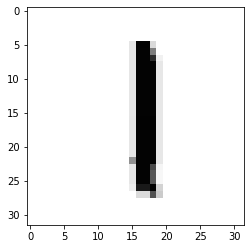

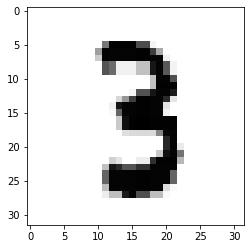

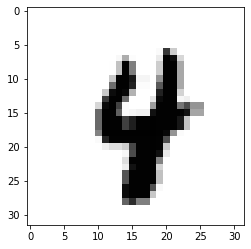

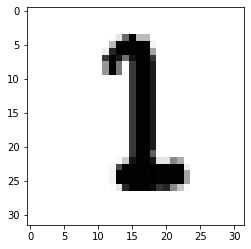

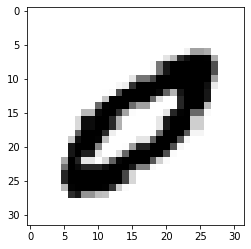

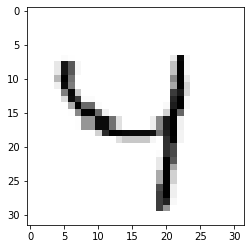

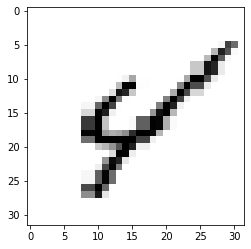

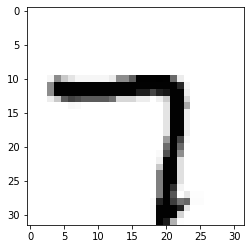

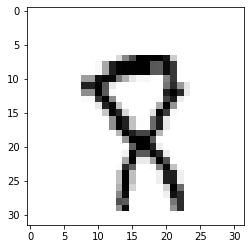

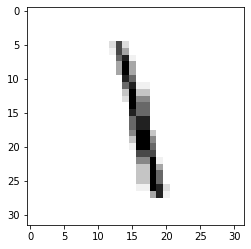

In [7]:
for i in range(10):
    img = train_minst_imgs[i].reshape((28,28))
    res = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)
    plt.imshow(res, cmap="Greys")
    plt.show()

## I.2 Extracting USPS

In [0]:
import h5py
with h5py.File('/content/drive/My Drive/DL ENSAE/usps.h5', 'r') as hf:
        train = hf.get('train')
        train_usps_imgs = train.get('data')[:]
        train_usps_labels = train.get('target')[:]
        test = hf.get('test')
        test_usps_imgs = test.get('data')[:]
        test_usps_labels = test.get('target')[:]

In [0]:
frac = 0.99 / 255
train_usps_imgs = np.asfarray(train_usps_imgs) * frac + 0.01
test_usps_imgs = np.asfarray(test_usps_imgs) * frac + 0.01

In [0]:
train_usps_imgs = random.choices(train_usps_imgs,k=Batch_size)

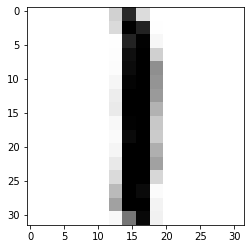

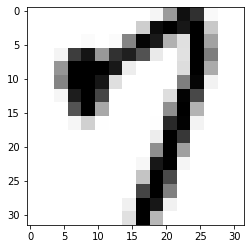

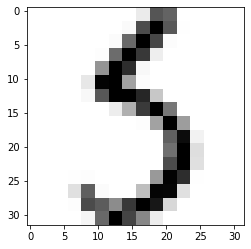

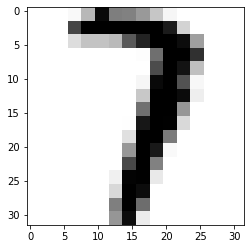

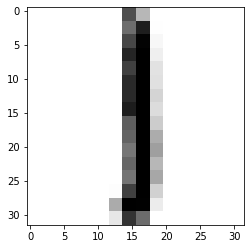

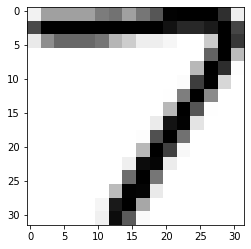

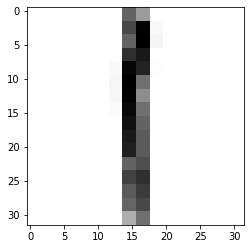

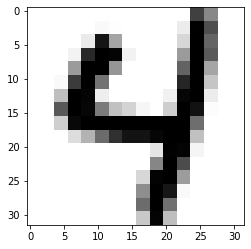

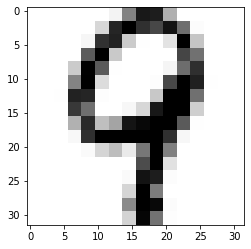

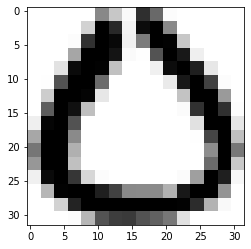

In [11]:
for i in range(10):
    img = train_usps_imgs[i].reshape((16,16))
    res = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)
    plt.imshow(res, cmap="Greys")
    plt.show()

##I.3 Preprocessing the datasets

In [0]:
train_minst_imgs=[a.reshape((28,28)) for a in train_minst_imgs]
train_usps_imgs=[a.reshape((16,16)) for a in train_usps_imgs]

In [0]:
train_minst_imgs=[cv2.resize(a, dsize=(32, 32), interpolation=cv2.INTER_NEAREST) for a in train_minst_imgs]
train_usps_imgs=[cv2.resize(a, dsize=(32, 32), interpolation=cv2.INTER_NEAREST) for a in train_usps_imgs]

In [0]:
train_MINST=[tf.convert_to_tensor(a, dtype=None, dtype_hint=None, name=None) for a in train_minst_imgs]
train_USPS=[tf.convert_to_tensor(a, dtype=None, dtype_hint=None, name=None) for a in train_usps_imgs]

In [0]:
train_MINST=[tf.expand_dims(a, axis=0, name=None) for a in train_MINST]
train_USPS=[tf.expand_dims(a, axis=0, name=None) for a in train_USPS]

In [0]:
train_MINST=[tf.expand_dims(a, axis=3, name=None) for a in train_MINST]
train_USPS=[tf.expand_dims(a, axis=3, name=None) for a in train_USPS]

In [0]:
#train_MINST=tf.concat([train_MINST,train_MINST,train_MINST], axis=4, name='concat')
#train_USPS=tf.concat([train_USPS,train_USPS,train_USPS], axis=4, name='concat')

In [18]:
train_MINST[1].shape

TensorShape([1, 32, 32, 1])

#II Architecture

In [19]:
#cell commented - used to display architecture graphs
'''from keras.utils.vis_utils import plot_model

image = keras.layers.Input(shape=(32, 32, 1))

conv1 = keras.layers.Conv2D(32, (17, 17))(image)
batchnorm1 = keras.layers.BatchNormalization()(conv1)
activ1= keras.layers.Activation("relu")(batchnorm1)

conv2 = keras.layers.Conv2D(64, (9, 9))(activ1)
batchnorm2 = keras.layers.BatchNormalization()(conv2)
activ2 = keras.layers.Activation("relu")(batchnorm2)

resnetbloc = keras.layers.Conv2D(64, (25, 25))(image)
batchnorm3 = keras.layers.BatchNormalization()(resnetbloc)
activ3 = keras.layers.Activation("relu")(batchnorm3)
add1 = keras.layers.Add()([activ3,activ2])

upconv1 = keras.layers.Conv2DTranspose(32,(9,9))(add1)
batchnorm4 = keras.layers.BatchNormalization()(upconv1)
activ4= keras.layers.Activation("relu")(batchnorm4)

upconv2 = keras.layers.Conv2DTranspose(1,(17,17))(activ4)
batchnorm5 = keras.layers.BatchNormalization()(upconv2)
activ5 = keras.layers.Activation("tanh",dtype='float32')(batchnorm5)

model = keras.Model(inputs=image, outputs=activ5)


# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True, to_file='generator.png')'''

'from keras.utils.vis_utils import plot_model\n\nimage = keras.layers.Input(shape=(32, 32, 1))\n\nconv1 = keras.layers.Conv2D(32, (17, 17))(image)\nbatchnorm1 = keras.layers.BatchNormalization()(conv1)\nactiv1= keras.layers.Activation("relu")(batchnorm1)\n\nconv2 = keras.layers.Conv2D(64, (9, 9))(activ1)\nbatchnorm2 = keras.layers.BatchNormalization()(conv2)\nactiv2 = keras.layers.Activation("relu")(batchnorm2)\n\nresnetbloc = keras.layers.Conv2D(64, (25, 25))(image)\nbatchnorm3 = keras.layers.BatchNormalization()(resnetbloc)\nactiv3 = keras.layers.Activation("relu")(batchnorm3)\nadd1 = keras.layers.Add()([activ3,activ2])\n\nupconv1 = keras.layers.Conv2DTranspose(32,(9,9))(add1)\nbatchnorm4 = keras.layers.BatchNormalization()(upconv1)\nactiv4= keras.layers.Activation("relu")(batchnorm4)\n\nupconv2 = keras.layers.Conv2DTranspose(1,(17,17))(activ4)\nbatchnorm5 = keras.layers.BatchNormalization()(upconv2)\nactiv5 = keras.layers.Activation("tanh",dtype=\'float32\')(batchnorm5)\n\nmodel = k

## II.1 Generators

In [0]:
def Generator():

  image = tf.keras.layers.Input(shape=(32, 32, 1))

  conv1 = tf.keras.layers.Conv2D(32, (17, 17))(image)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
  activ1= tf.keras.layers.Activation("relu")(batchnorm1)

  conv2 = tf.keras.layers.Conv2D(64, (9, 9))(activ1)
  batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
  activ2 = tf.keras.layers.Activation("relu")(batchnorm2)

  resnetbloc = tf.keras.layers.Conv2D(64, (25, 25))(image)
  batchnorm3 = tf.keras.layers.BatchNormalization()(resnetbloc)
  activ3 = tf.keras.layers.Activation("relu")(batchnorm3)
  add1 = tf.keras.layers.Add()([activ3,activ2])

  upconv1 = tf.keras.layers.Conv2DTranspose(32,(9,9))(add1)
  batchnorm4 = tf.keras.layers.BatchNormalization()(upconv1)
  activ4= tf.keras.layers.Activation("relu")(batchnorm4)

  upconv2 = tf.keras.layers.Conv2DTranspose(1,(17,17))(activ4)
  batchnorm5 = tf.keras.layers.BatchNormalization()(upconv2)
  activ5 = tf.keras.layers.Activation("tanh",dtype='float32')(batchnorm5)

  model_gen = tf.keras.Model(inputs=image, outputs=activ5)
  
  return(model_gen)

In [21]:
'''def Long_Generator():
  image = tf.keras.layers.Input(shape=(32, 32, 1))

  conv1 = tf.keras.layers.Conv2D(32, (17, 17))(image)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
  activ1= tf.keras.layers.Activation("relu")(batchnorm1)

  conv2 = tf.keras.layers.Conv2D(64, (9, 9))(activ1)
  batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
  activ2 = tf.keras.layers.Activation("relu")(batchnorm2)

  conv3 = tf.keras.layers.Conv2D(128, (5, 5))(activ2)
  batchnorm3 = tf.keras.layers.BatchNormalization()(conv3)
  activ3 = tf.keras.layers.Activation("relu")(batchnorm3)

  conv4 = tf.keras.layers.Conv2D(256, (3, 3))(activ3)
  batchnorm4 = tf.keras.layers.BatchNormalization()(conv4)
  activ4 = tf.keras.layers.Activation("relu")(batchnorm4)

  convresidual = tf.keras.layers.Conv2D(256, (31, 31))(image)
  batchnorm5 = tf.keras.layers.BatchNormalization()(convresidual)
  activ5 = tf.keras.layers.Activation("relu")(batchnorm5)
  add1 = tf.keras.layers.Add()([activ4,activ5])

  upconv1 = tf.keras.layers.Conv2DTranspose(128,(3,3))(activ5)
  batchnorm6 = tf.keras.layers.BatchNormalization()(upconv1)
  activ6 = tf.keras.layers.Activation("relu")(batchnorm6)

  upconv2 = tf.keras.layers.Conv2DTranspose(64,(5,5))(activ6)
  batchnorm7 = tf.keras.layers.BatchNormalization()(upconv2)
  activ7 = tf.keras.layers.Activation("relu")(batchnorm7)

  upconv3 = tf.keras.layers.Conv2DTranspose(32,(9,9))(activ7)
  batchnorm8 = tf.keras.layers.BatchNormalization()(upconv3)
  activ8 = tf.keras.layers.Activation("relu")(batchnorm8)

  upconv4 = tf.keras.layers.Conv2DTranspose(1,(17,17))(activ8)
  batchnorm6 = tf.keras.layers.BatchNormalization()(upconv4)
  activ9 = tf.keras.layers.Activation("tanh",dtype='float32')(batchnorm6)

  model_gen = tf.keras.Model(inputs=image, outputs=activ9)
  
  return(model_gen)'''

'def Long_Generator():\n  image = tf.keras.layers.Input(shape=(32, 32, 1))\n\n  conv1 = tf.keras.layers.Conv2D(32, (17, 17))(image)\n  batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)\n  activ1= tf.keras.layers.Activation("relu")(batchnorm1)\n\n  conv2 = tf.keras.layers.Conv2D(64, (9, 9))(activ1)\n  batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)\n  activ2 = tf.keras.layers.Activation("relu")(batchnorm2)\n\n  conv3 = tf.keras.layers.Conv2D(128, (5, 5))(activ2)\n  batchnorm3 = tf.keras.layers.BatchNormalization()(conv3)\n  activ3 = tf.keras.layers.Activation("relu")(batchnorm3)\n\n  conv4 = tf.keras.layers.Conv2D(256, (3, 3))(activ3)\n  batchnorm4 = tf.keras.layers.BatchNormalization()(conv4)\n  activ4 = tf.keras.layers.Activation("relu")(batchnorm4)\n\n  convresidual = tf.keras.layers.Conv2D(256, (31, 31))(image)\n  batchnorm5 = tf.keras.layers.BatchNormalization()(convresidual)\n  activ5 = tf.keras.layers.Activation("relu")(batchnorm5)\n  add1 = tf.keras.layers.Add()(

In [22]:
'''def Short_Generator():

    image = tf.keras.layers.Input(shape=(32, 32, 1))

    conv1 = tf.keras.layers.Conv2D(32, (17, 17))(image)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
    activ1= tf.keras.layers.Activation("relu")(batchnorm1)

    upconv2 = tf.keras.layers.Conv2DTranspose(1,(17,17))(activ2)
    batchnorm5 = tf.keras.layers.BatchNormalization()(upconv2)
    activ5 = tf.keras.layers.Activation("tanh",dtype='float32')(batchnorm5)

    model_gen = tf.keras.Model(inputs=image, outputs=activ5)
  
    return(model_gen)'''

'def Short_Generator():\n\n    image = tf.keras.layers.Input(shape=(32, 32, 1))\n\n    conv1 = tf.keras.layers.Conv2D(32, (17, 17))(image)\n    batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)\n    activ1= tf.keras.layers.Activation("relu")(batchnorm1)\n\n    upconv2 = tf.keras.layers.Conv2DTranspose(1,(17,17))(activ2)\n    batchnorm5 = tf.keras.layers.BatchNormalization()(upconv2)\n    activ5 = tf.keras.layers.Activation("tanh",dtype=\'float32\')(batchnorm5)\n\n    model_gen = tf.keras.Model(inputs=image, outputs=activ5)\n  \n    return(model_gen)'

## II.2 Discriminators

In [0]:
def Discriminator():

  image = tf.keras.layers.Input(shape=(32, 32, 1))

  conva = tf.keras.layers.Conv2D(32, (17, 17))(image)
  batchnorma = tf.keras.layers.BatchNormalization()(conva)
  activa= tf.keras.layers.Activation("relu")(batchnorma)

  convb = tf.keras.layers.Conv2D(64, (9, 9))(activa)
  batchnormb = tf.keras.layers.BatchNormalization()(convb)
  activb = tf.keras.layers.Activation("relu")(batchnormb)

  convc = tf.keras.layers.Conv2D(128, (5, 5))(activb)
  batchnormc = tf.keras.layers.BatchNormalization()(convc)
  activc = tf.keras.layers.Activation("relu")(batchnormc)

  flattened = tf.keras.layers.Flatten()(activc)
  output = tf.keras.layers.Dense(1)(flattened)

  model_dis = tf.keras.Model(inputs=image, outputs=output)
  
  return(model_dis)

In [24]:
'''def Long_Discriminator():

    image = tf.keras.layers.Input(shape=(32, 32, 1))

    conva = tf.keras.layers.Conv2D(32, (17, 17))(image)
    batchnorma = tf.keras.layers.BatchNormalization()(conva)
    activa= tf.keras.layers.Activation("relu")(batchnorma)

    convb = tf.keras.layers.Conv2D(64, (9, 9))(activa)
    batchnormb = tf.keras.layers.BatchNormalization()(convb)
    activb = tf.keras.layers.Activation("relu")(batchnormb)

    convc = tf.keras.layers.Conv2D(128, (5, 5))(activb)
    batchnormc = tf.keras.layers.BatchNormalization()(convc)
    activc = tf.keras.layers.Activation("relu")(batchnormc)

    convd = tf.keras.layers.Conv2D(256, (3, 3))(activb)
    batchnormd = tf.keras.layers.BatchNormalization()(convd)
    activd = tf.keras.layers.Activation("relu")(batchnormd)
    
    flattened = tf.keras.layers.Flatten()(activd)
    output = tf.keras.layers.Dense(1)(flattened)

    model_dis = tf.keras.Model(inputs=image, outputs=output)
  
    return(model_dis)'''

'def Long_Discriminator():\n\n    image = tf.keras.layers.Input(shape=(32, 32, 1))\n\n    conva = tf.keras.layers.Conv2D(32, (17, 17))(image)\n    batchnorma = tf.keras.layers.BatchNormalization()(conva)\n    activa= tf.keras.layers.Activation("relu")(batchnorma)\n\n    convb = tf.keras.layers.Conv2D(64, (9, 9))(activa)\n    batchnormb = tf.keras.layers.BatchNormalization()(convb)\n    activb = tf.keras.layers.Activation("relu")(batchnormb)\n\n    convc = tf.keras.layers.Conv2D(128, (5, 5))(activb)\n    batchnormc = tf.keras.layers.BatchNormalization()(convc)\n    activc = tf.keras.layers.Activation("relu")(batchnormc)\n\n    convd = tf.keras.layers.Conv2D(256, (3, 3))(activb)\n    batchnormd = tf.keras.layers.BatchNormalization()(convd)\n    activd = tf.keras.layers.Activation("relu")(batchnormd)\n    \n    flattened = tf.keras.layers.Flatten()(activd)\n    output = tf.keras.layers.Dense(1)(flattened)\n\n    model_dis = tf.keras.Model(inputs=image, outputs=output)\n  \n    return(mode

In [25]:
'''def Short_Discriminator():

    image = tf.keras.layers.Input(shape=(32, 32, 1))

    conva = tf.keras.layers.Conv2D(32, (17, 17))(image)
    batchnorma = tf.keras.layers.BatchNormalization()(conva)
    activa= tf.keras.layers.Activation("relu")(batchnorma)

    convb = tf.keras.layers.Conv2D(64, (9, 9))(activa)
    batchnormb = tf.keras.layers.BatchNormalization()(convb)
    activb = tf.keras.layers.Activation("relu")(batchnormb)

    flattened = tf.keras.layers.Flatten()(activb)
    output = tf.keras.layers.Dense(1)(flattened)

    model_dis = tf.keras.Model(inputs=image, outputs=output)
  
    return(model_dis)'''

'def Short_Discriminator():\n\n    image = tf.keras.layers.Input(shape=(32, 32, 1))\n\n    conva = tf.keras.layers.Conv2D(32, (17, 17))(image)\n    batchnorma = tf.keras.layers.BatchNormalization()(conva)\n    activa= tf.keras.layers.Activation("relu")(batchnorma)\n\n    convb = tf.keras.layers.Conv2D(64, (9, 9))(activa)\n    batchnormb = tf.keras.layers.BatchNormalization()(convb)\n    activb = tf.keras.layers.Activation("relu")(batchnormb)\n\n    flattened = tf.keras.layers.Flatten()(activb)\n    output = tf.keras.layers.Dense(1)(flattened)\n\n    model_dis = tf.keras.Model(inputs=image, outputs=output)\n  \n    return(model_dis)'

In [26]:
train_USPS[1].shape

TensorShape([1, 32, 32, 1])

In [0]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)

  display_list = [tf.squeeze(test_input[0]), tf.squeeze(prediction[0])]
  titles = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.title(titles[i])
    plt.imshow(display_list[i], cmap="Greys")
    plt.show()

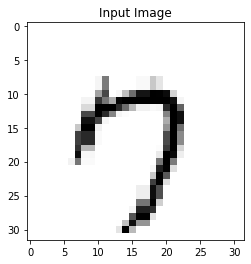

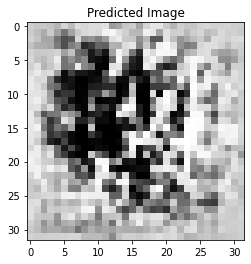

In [29]:
generate_images(generator_g,train_MINST[60])

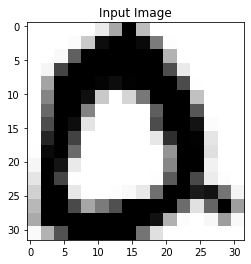

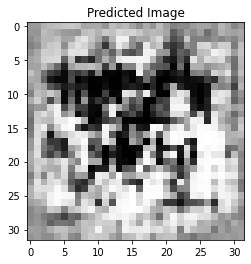

In [30]:
generate_images(generator_f,train_USPS[300])

#III Training

## III.1 Loss functions

In [0]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float64) - tf.cast(cycled_image, tf.float64)))
  loss1= tf.cast(loss1, tf.float32)
  return Lambda * loss1

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float64) - tf.cast(same_image, tf.float64)))
  loss= tf.cast(loss, tf.float32)
  return Lambda * Identity_loss_importance * loss

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## III.2 Defining training loop (and checkpoint)

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)
    
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)
    
    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

##III.3 Performing training




In [0]:
from IPython.display import clear_output

In [0]:
MINST_images=tf.data.Dataset.from_tensor_slices(train_MINST)
USPS_images=tf.data.Dataset.from_tensor_slices(train_USPS)

In [0]:
#tf.config.experimental_run_functions_eagerly(True)

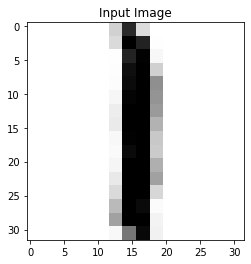

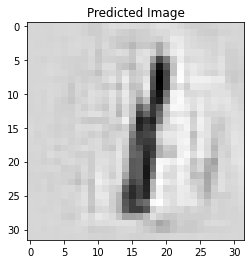

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-40
Time taken for epoch 40 is 17.703006744384766 sec



In [42]:
for epoch in range(Epochs):
  start = time.time()

  n = 0

  for image_x,image_y in tf.data.Dataset.zip((MINST_images, USPS_images)):
    train_step(image_x, image_y)
    if n % (Batch_size/10) == 0:
      print (math.floor(100*n/Batch_size),' % epoch done')
    n+=1

  clear_output(wait=True)
  generate_images(generator_f, train_USPS[0])

  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

#IV Generation on test set

In [0]:
test_usps_imgs=[a.reshape((16,16)) for a in test_usps_imgs]
test_usps_imgs=[cv2.resize(a, dsize=(32, 32), interpolation=cv2.INTER_NEAREST) for a in test_usps_imgs]
test_USPS=[tf.convert_to_tensor(a, dtype=None, dtype_hint=None, name=None) for a in test_usps_imgs]
test_USPS=[tf.expand_dims(a, axis=0, name=None) for a in test_USPS]
test_USPS=[tf.expand_dims(a, axis=3, name=None) for a in test_USPS]

In [44]:
test_usps_imgs[1]

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]])

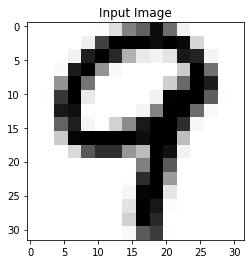

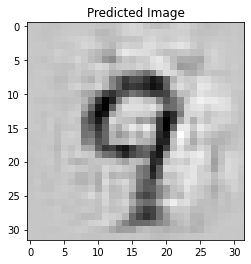

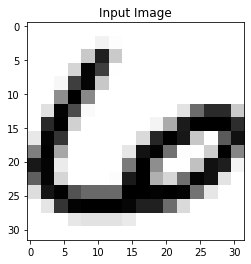

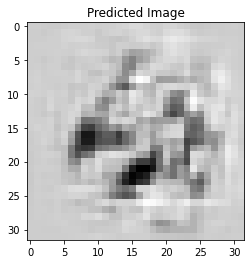

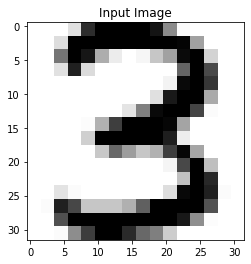

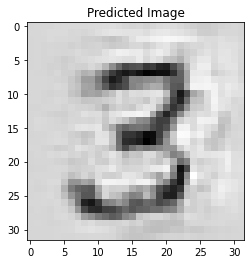

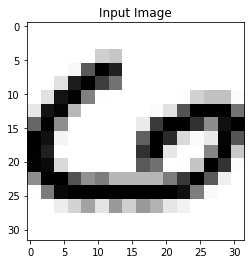

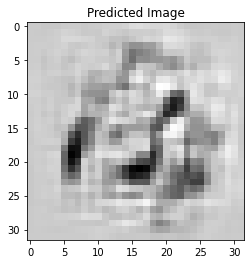

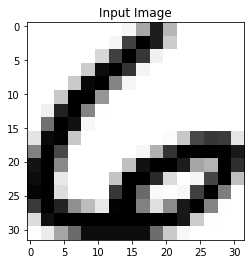

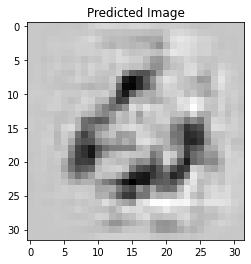

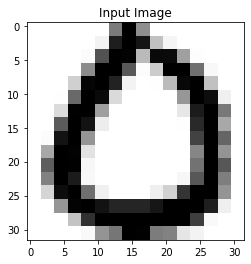

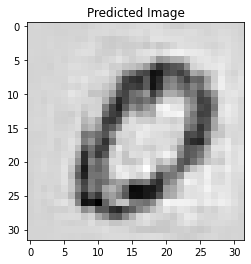

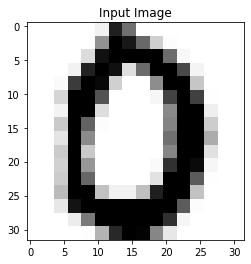

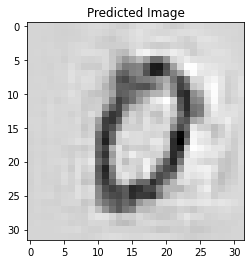

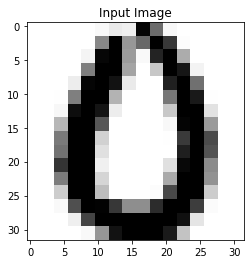

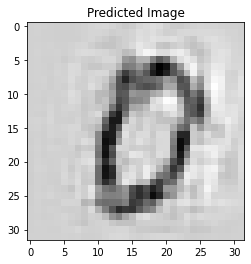

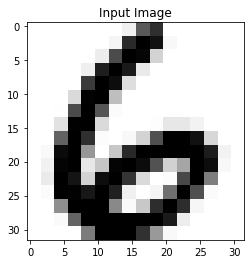

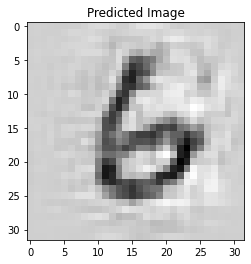

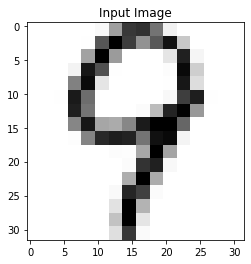

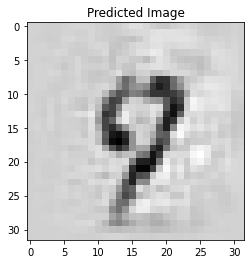

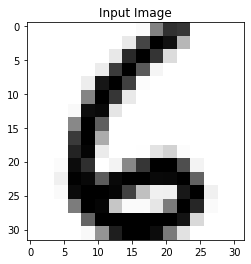

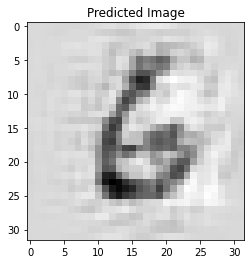

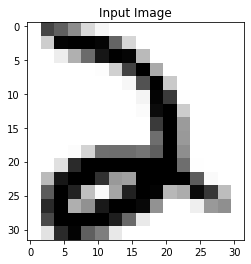

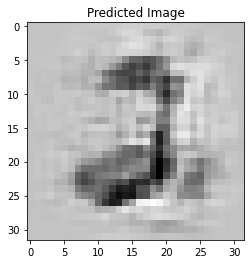

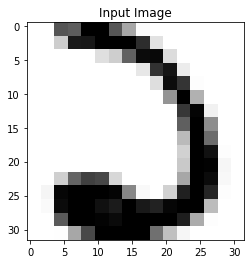

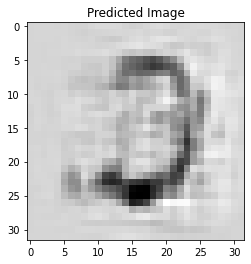

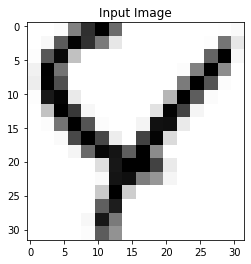

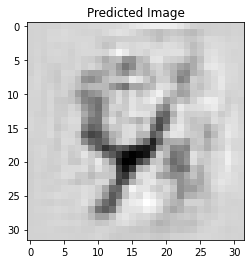

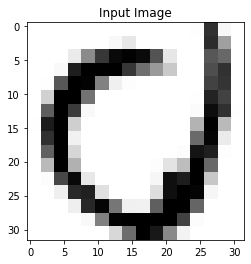

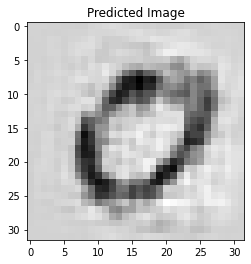

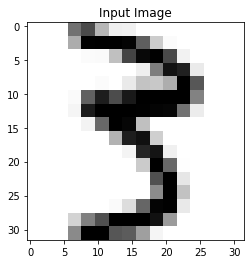

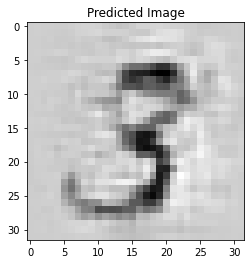

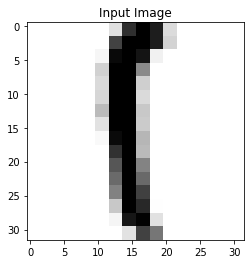

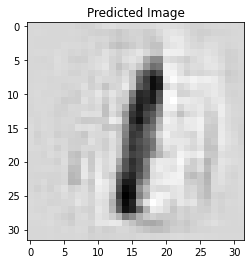

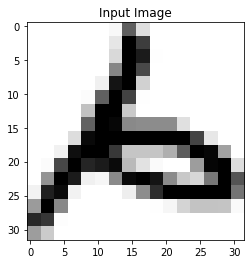

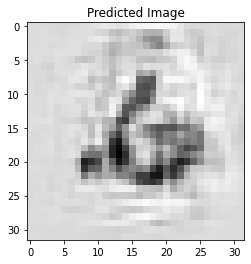

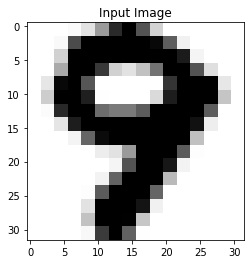

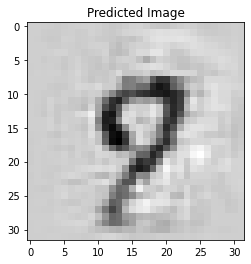

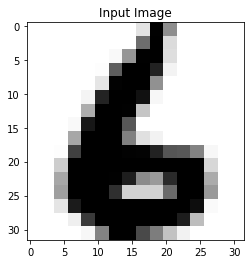

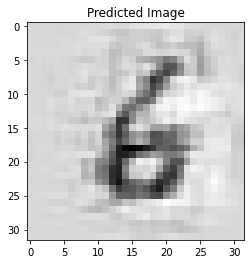

In [45]:
for i in range(20):
  generate_images(generator_f, test_USPS[i])